# Pitch Transcription

In [26]:
%matplotlib inline
from pathlib import Path
import pandas as pd 
import numpy as np, scipy, matplotlib.pyplot as plt, sklearn, IPython.display as ipd
import librosa, librosa.display

## Import Data

In [27]:
# load a scale
x, sr = librosa.load('MAPS_ISOL_CH0.3_F_AkPnBcht.wav', sr=44100)

In [28]:
# playback
ipd.Audio(x, rate=sr)

In [29]:
N = len(x)
print(N,'number of samples')

2515982 number of samples


In [30]:
# extract the relevant ground truths 
ground_truths = pd.read_csv('MAPS_ISOL_CH0.3_F_AkPnBcht.txt', sep='\t')
ground_truths_sample = ground_truths[['OnsetTime','MidiPitch']]
ground_truths_sample.head()

OnsetTime  MidiPitch
0   0.500004         21
1   0.810014         22
2   1.120020         23
3   1.430030         24
4   1.740040         25

In [31]:
# extract unique MIDI notes 
unique_midi = np.unique(ground_truths_sample.MidiPitch)
unique_midi

array([ 21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108], dtype=int64)

In [32]:
# how many unique notes?
number_notes = len(unique_midi)
number_notes

88

## Onset Detection

(1500, 1800)

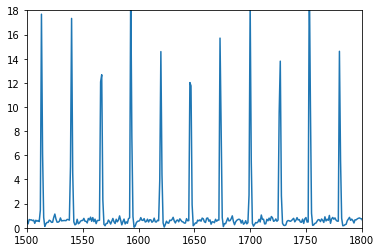

In [33]:
# specify some overlap that corresponds to 174 frames
hop_length = 512 
# Find the onsets using spectral flux 
onset_env = librosa.onset.onset_strength(x, 
                                         sr=sr,
                                         hop_length=hop_length)

# plot the onset envelope 
plt.plot(onset_env);
plt.ylim(0,18);
plt.xlim((1500,1800))

In [34]:
# find the onsets
# hop length of 512 gives 174 frames
hop_length = 512

# peak is picked based on satisfying these conditions: 
# x[n] == max(x[n - pre_max:n + post_max])
# x[n] >= mean(x[n - pre_avg:n + post_avg]) + delta
# n - previous_n > wait

onset_samples = librosa.onset.onset_detect(x,
                                           sr=sr, 
                                           units='samples', 
                                           hop_length=hop_length, 
                                           pre_max=20,
                                           post_max=20,
                                           pre_avg=100,
                                           post_avg=100,
                                           delta=0.02,
                                           wait=0)

# define onset_boundaries 
onset_boundaries = np.concatenate([[0], onset_samples, [N]])
onset_boundary_times = librosa.samples_to_time(onset_boundaries, sr=sr)
onset_boundary_times = onset_boundary_times + initial_time

# for mir_eval calculation
onset_times = librosa.samples_to_time(onset_samples, sr=sr)
# add the initial time
onset_times = onset_times + initial_time

onset_boundary_times

array([ 0.        ,  0.52244898,  0.83591837,  1.13777778,  1.46285714,
        1.76471655,  2.07818594,  2.38004535,  2.69351474,  3.00698413,
        3.32045351,  3.62231293,  3.93578231,  4.2492517 ,  4.55111111,
        4.8645805 ,  5.17804989,  5.49151927,  5.80498866,  6.10684807,
        6.42031746,  6.72217687,  7.03564626,  7.34911565,  7.65097506,
        7.96444444,  8.27791383,  8.57977324,  8.89324263,  9.19510204,
        9.50857143,  9.82204082, 10.1355102 , 10.43736961, 10.750839  ,
       11.06430839, 11.3661678 , 11.67963719, 11.99310658, 12.29496599,
       12.60843537, 12.92190476, 13.22376417, 13.53723356, 13.85070295,
       14.15256236, 14.46603175, 14.77950113, 15.08136054, 15.39482993,
       15.70829932, 16.01015873, 16.32362812, 16.63709751, 16.95056689,
       17.2524263 , 17.56589569, 17.87936508, 18.19283447, 18.49469388,
       18.80816327, 19.11002268, 19.42349206, 19.73696145, 20.05043084,
       20.35229025, 20.66575964, 20.97922902, 21.28108844, 21.59

## Estimate pitch

In [35]:
# estimate pitch using the autocorrelation method
def estimate_pitch(segment, sr, f_min=20, f_max=4200):
    # Compute autocorrelation of input segment.
    r = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/f_max
    i_max = sr/f_min
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0

In [36]:
# generate pure sine tone
def generate_sine(f0, sr, n_duration):
    # set a duration time for the tone
    n = np.arange(n_duration)
    return 0.2*np.sin(2*np.pi*f0*n/float(sr))

In [37]:
# estimate the pitch and and generate a sine wave
def estimate_pitch_and_generate_sine(x, onset_samples, i, sr):
    # define boundaries of segment to calculate pitch
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    # estimate pitch
    f0 = estimate_pitch(x[n0:n1], sr)
    return generate_sine(f0, sr, n1-n0)

In [ ]:
# create the estimated music transcription
# convert to array 
y = np.concatenate([
    estimate_pitch_and_generate_sine(x, onset_boundaries, i, sr=sr)
    for i in range(len(onset_boundaries)-1)
])

In [ ]:
ipd.Audio(y, rate=sr)

## Evaluation of AMT performance

In [ ]:
# mir eval 
import mir_eval 

In [ ]:
# estimate f0 using ACR method
f0_freq = []
for i in range(len(onset_boundaries)-1): 
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0_freq.append(estimate_pitch(x[n0:n1],sr))
    
MIDI_nums = np.around(librosa.hz_to_midi(f0_freq))

In [ ]:
# place values in appropriate format 
ref_time = np.array(ground_truths_sample.OnsetTime.values)
ref_freqs = np.array(librosa.midi_to_hz(ground_truths_sample.MidiPitch.values))
est_time = np.array(transcription.OnsetTime.values)
est_freqs = np.array(librosa.midi_to_hz(transcription.MidiPitch.values))

# evaluate the quality of the transcription 
mir_eval.melody.evaluate(ref_time,ref_freqs,est_time,est_freqs)